In [0]:
import torch

In [0]:
from pathlib import Path

data_link = "https://download.pytorch.org/tutorial/"
filename = "data.zip"
data_path = Path("./data")

if not data_path.exists():
    data_path.mkdir(parents=True)

In [0]:
import requests

if not (data_path / filename).exists():
    content = requests.get(data_link + filename).content
    (data_path / filename).open("wb").write(content)

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile(data_path / filename) as f:
    f.extractall(data_path)

In [6]:
!ls data/data/names

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [7]:
!python3 -m pip install unidecode

     |████████████████████████████████| 245kB 4.7MB/s 


In [0]:
import glob
import os
import unidecode

def findFiles(path):
    return glob.glob(path)

# print(findFiles("data/data/names/*.txt"))

def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unidecode.unidecode(n) for n in lines]

all_categories = []
category_lines = {}

for filename in findFiles("data/data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
category_lines[all_categories[2]][:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

In [10]:
import string

all_letters = string.ascii_letters + " .,;'"

def letter_to_index(letter):
    return all_letters.find(letter)

def letter_one_hot(letter):
    res = torch.zeros(len(all_letters))
    res[letter_to_index(letter)] = 1
    return res
    
def line_to_tensor(line):
    res = torch.zeros(len(line), 1, len(all_letters))  # WHY THIS SHAPE IN PARTICULAR?!?!
    for l_i, letter in enumerate(line):
        res[l_i][0][letter_to_index(letter)] = 1
    
    return res

print(letter_one_hot("X"))
print(line_to_tensor("Kinshuk").shape)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0.])
torch.Size([7, 1, 57])


In [28]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inp, hidden):
        combined = torch.cat((inp, hidden), 1) #what does 1 do here?
        hidden = self.i2h(combined)
        output = self.logsoftmax(self.i2o(combined))
        return output, hidden
    
    def hidden_initial(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
net = RNN(len(all_letters), n_hidden, n_categories)
print(net)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (logsoftmax): LogSoftmax()
)


In [12]:
word_tensor = line_to_tensor("laptop")
hidden = net.hidden_initial()

with torch.no_grad():
    output, next_hidden = net(word_tensor[0], hidden)

print(output)
print(next_hidden)

tensor([[-2.8889, -2.9365, -2.9535, -2.9496, -2.8199, -2.8956, -2.9550, -2.8208,
         -2.7820, -2.7962, -2.8791, -2.9330, -2.9044, -2.8961, -2.8400, -2.8650,
         -2.9467, -2.9966]])
tensor([[ 5.2664e-02, -6.5702e-02, -7.6484e-02, -7.3609e-03, -2.9969e-02,
         -4.1862e-02,  1.0623e-01,  7.3762e-02,  5.1191e-02,  1.9457e-02,
          8.5199e-02,  7.3734e-03, -8.0178e-02,  2.5765e-02, -1.3017e-01,
          7.7604e-02,  3.5618e-02,  8.2919e-02,  1.0213e-01, -6.6535e-02,
          2.2241e-03, -7.2195e-02,  1.1873e-01, -7.8226e-02,  1.8246e-05,
         -5.3643e-02,  4.6126e-03,  6.3346e-02,  1.1524e-01,  7.6791e-02,
         -9.2321e-02, -8.5055e-02,  3.3518e-02, -5.4979e-03,  9.4237e-02,
         -4.9768e-02, -5.6330e-02,  1.6301e-02, -7.4345e-02, -7.1956e-02,
          9.6549e-02, -9.7942e-02, -2.8702e-02,  5.8160e-02,  4.1324e-02,
          6.2331e-02,  1.3388e-02, -3.3177e-02, -1.9148e-02, -5.4082e-02,
          2.4834e-02,  4.1233e-02,  3.7883e-02, -1.6741e-02,  5.9003e

In [13]:
def category_from_output(output):
    top_val, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

('French', 8)


In [14]:
import random

def random_training_example():
    category = random.choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line = random.choice(category_lines[category])
    line_tensor = line_to_tensor(line)
    return category, category_tensor, line, line_tensor

for i in range(10):
    category, category_tensor, line, line_tensor = random_training_example()
    print("category: {} shape: {} | line: {} shape: {}".format(category, category_tensor.shape, line, line_tensor.shape))

category: German shape: torch.Size([1]) | line: Schwarz shape: torch.Size([7, 1, 57])
category: Russian shape: torch.Size([1]) | line: Yagupa shape: torch.Size([6, 1, 57])
category: Czech shape: torch.Size([1]) | line: Faltysek shape: torch.Size([8, 1, 57])
category: Arabic shape: torch.Size([1]) | line: Ganim shape: torch.Size([5, 1, 57])
category: French shape: torch.Size([1]) | line: Allard shape: torch.Size([6, 1, 57])
category: Japanese shape: torch.Size([1]) | line: Maruyama shape: torch.Size([8, 1, 57])
category: Spanish shape: torch.Size([1]) | line: Oleastro shape: torch.Size([8, 1, 57])
category: Spanish shape: torch.Size([1]) | line: Gonzales shape: torch.Size([8, 1, 57])
category: Scottish shape: torch.Size([1]) | line: Mccallum shape: torch.Size([8, 1, 57])
category: Korean shape: torch.Size([1]) | line: So shape: torch.Size([2, 1, 57])


In [0]:
neglog_loss = nn.NLLLoss()

In [0]:
def train(category_tensor, line_tensor, net, lr):
    hidden = net.hidden_initial()
    
    net.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)
    
    loss = neglog_loss(output, category_tensor)
    loss.backward()
    
    for p in net.parameters():
        p.grad.clamp_(-1, 1)
    
    for p in net.parameters():
        p.data.add_(-lr * p.grad.data)
    
    return output, loss.item()

In [0]:
import time
import math



current_loss = 0
all_losses = []

def timeSince(start_time):
    now = time.time()
    sec = now - start_time
    min = math.floor(sec / 60)
    sec -= min * 60
    return "{}m {}s".format(min, sec)

def train_loop(net, n_iters=1000000, print_every=5000, plot_every=5000, lr=0.005):
    start_time = time.time()
    current_loss = 0
    
    for i in range(n_iters):
        category, category_tensor, line, line_tensor = random_training_example()
        output, loss = train(category_tensor, line_tensor, net, lr)
        current_loss += loss
        
        if i % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ ({})'.format(category)
            print("#{} {}%% ({}) {} {} / {} {}".format(
                i,
                i * 100 / n_iters,
                timeSince(start_time),
                loss,
                line,
                guess,
                correct
            ))
        
#         all_losses.append(loss)

        if i % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

In [31]:
train_loop(net, n_iters=50000, lr=0.005)
train_loop(net, n_iters=50000, lr=0.001)
train_loop(net, n_iters=50000, lr=0.0005)
train_loop(net, n_iters=50000, lr=0.0001)

#0 0.0%% (0m 0.006636381149291992s) 1.8541642427444458 Kalogeria / Russian ✗ (Greek)
#5000 10.0%% (0m 8.155802726745605s) 3.201214075088501 Zuraw / Arabic ✗ (Polish)
#10000 20.0%% (0m 15.9251070022583s) 1.9072155952453613 Steele / French ✗ (English)
#15000 30.0%% (0m 23.70411515235901s) 3.9105615615844727 Wright / French ✗ (Scottish)
#20000 40.0%% (0m 31.40263056755066s) 1.5611915588378906 Gray / Scottish ✓
#25000 50.0%% (0m 39.170746088027954s) 1.4482754468917847 Ortiz / Spanish ✓
#30000 60.0%% (0m 46.90133357048035s) 0.7497859001159668 Cathain / Irish ✓
#35000 70.0%% (0m 54.67768883705139s) 0.48497724533081055 Kojima / Japanese ✓
#40000 80.0%% (1m 2.4432590007781982s) 1.859940767288208 Nyrko / Polish ✗ (Russian)
#45000 90.0%% (1m 10.199062824249268s) 0.448610782623291 Jung  / Korean ✓
#0 0.0%% (0m 0.0011587142944335938s) 1.3674941062927246 Cha / Vietnamese ✗ (Korean)
#5000 10.0%% (0m 7.7859697341918945s) 0.7935202121734619 Brown / Scottish ✓
#10000 20.0%% (0m 15.514846563339233s) 1.1

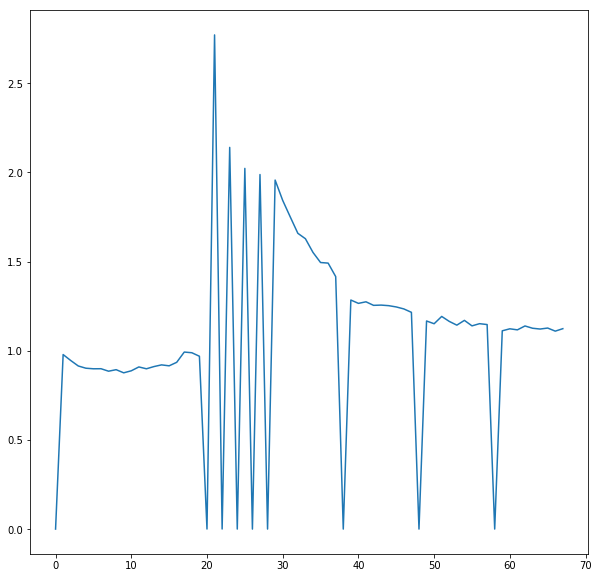

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [0]:
confusion_matrix = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate_tensor(net, line_tensor):
    hidden = net.hidden_initial()
    
    output = None
    with torch.no_grad():
        for i in range(line_tensor.shape[0]):
            output, hidden = net(line_tensor[i], hidden)
    
    return output

def predict_single(net, line, top_k=3):
    with torch.no_grad():
        output = evaluate_tensor(net, line_to_tensor(line))
        
        top_v, top_i = output.topk(top_k)
#         print(top_v, top_i)
        
        for i in range(top_k):
            value = top_v[0][i].item()
            category_index = top_i[0][i].item()
            print("{}) {} ({})".format(i+1, all_categories[category_index], value))

In [0]:
for i in range(n_confusion):
    category, category_tensor, line, line_tensor = random_training_example()
    output = evaluate_tensor(net, line_tensor)
    guess, guess_i = category_from_output(output)
    real_category_i = all_categories.index(category)
    confusion_matrix[real_category_i][guess_i] += 1

([<matplotlib.axis.YTick at 0x7fd779e9f898>,
 <a list of 18 Text yticklabel objects>)

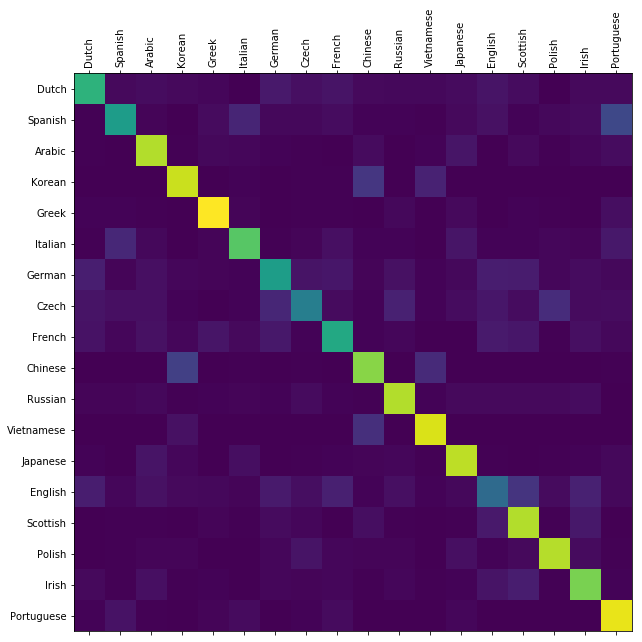

In [34]:
import numpy as np

plt.rcParams["figure.figsize"] = [10, 10]
plt.matshow(confusion_matrix)
plt.xticks(np.arange(len(all_categories)), all_categories, rotation=90)
plt.yticks(np.arange(len(all_categories)), all_categories)

In [66]:
s = "Kinshuk"
predict_single(net, s)

1) Czech (-1.1865978240966797)
2) Russian (-1.4398428201675415)
3) Japanese (-2.349774122238159)
